# Классификация новостей

In [33]:
# !pip install razdel
# !pip install swifter
# !pip install pymorphy2
# !pip install hyperopt
# !pip install lightgbm
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from tqdm import tqdm
tqdm.pandas()

import timeit
from string import punctuation
import re
import pymorphy2


from sklearn.preprocessing import LabelEncoder 

import razdel as rzd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from joblib import dump, load

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, make_scorer, roc_curve
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score

from sklearn.base import clone
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, ElasticNet
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Получение данных

In [2]:
news = []
with open('corpus.json') as file:
    for line in file:
        news.append(json.loads(line))

## 2. Обзор данных

Для начала следует взглянуть на данные. Перед обработкой текста, векторизацией и токенизацией следует отметить несколько важных особенностей датасета (выводы из таблицы ниже):
* Тексты содержат в основном русские слова, поэтому не все библиотеки обработки естественного языка могут подойти. К счастью, существуют библиотеки, которые достаточно хорошо работают с русскоязычными текстами. Данная проблема возникает на этапе предобработки текста (токенизации, лемматизации, удалении стоп-слов)
* Так как основная задача - классифицировать тексты, то следует также обратить внимание на количество классов, а также на их баланс. Это может повлиять на выбор основных метрик, а также стратегий классификации (множественной)
* Кажется, теги очень часто содержат название категории (а возможно и всегда).
* Возможно, многие тексты начинаются с предложений определенной структуры (ГОРОД, дата - РИА Новости).

In [3]:
df = pd.DataFrame(news)
df

,article_id,title,category,tags,text
0,https://ria.ru/20220116/volki-1768107463.html,Прокуратура проверяет сообщения о нападениях в...,incidents,"[Происшествия, Новгородская область]","С.-ПЕТЕРБУРГ, 16 янв - РИА Новости. Прокуратур..."
1,https://ria.ru/20220116/salyut-1768103772.html,В Минводах салют выбил окна в многоэтажке и по...,incidents,"[Происшествия, Минеральные Воды]","ПЯТИГОРСК, 16 янв - РИА Новости. Окна многоква..."
2,https://ria.ru/20220116/dtp-1768101756.html,В ДПТ под Красноярском погибли два ребенка и в...,incidents,"[Происшествия, Красноярск, Сосновоборск, Красн...","КРАСНОЯРСК, 16 янв - РИА Новости. Два малолетн..."
3,https://ria.ru/20220116/pozhar-1768079480.html,В Новосибирске потушили загоревшуюся цистерну ...,incidents,"[Происшествия, Новосибирская область, Октябрьс...","НОВОСИБИРСК, 16 янв – РИА Новости. Загоревшуюс..."
4,https://ria.ru/20220116/tsisterna-1768078676.html,В Новосибирске загорелась цистерна с бензином,incidents,"[Происшествия, Новосибирская область, Октябрьс...","НОВОСИБИРСК, 16 янв – РИА Новости. Цистерна с ..."
...,...,...,...,...,...
7388,https://radiosputnik.ria.ru/20210810/tank-1745...,Российская армия получит 20 новых танков Т-14 ...,defense_safety,"[В России, Безопасность, Технологии, Армата, А...","МОСКВА, 10 августа/ Радио Sputnik. В Вооруженн..."
7389,https://ria.ru/20210810/tsirkon-1745190858.html,"Испытания гиперзвуковой ракеты ""Циркон"" заверш...",defense_safety,"[Новое оружие России, Безопасность, Министерст...","МОСКВА, 10 авг - РИА Новости. Государственные ..."
7390,https://ria.ru/20210810/tanki-1745189008.html,Вооруженные силы до конца года получат 20 нове...,defense_safety,"[Новое оружие России, Безопасность, Министерст...","МОСКВА, 10 авг — РИА Новости. До конца года в ..."
7391,https://ria.ru/20210810/avangard-1745187277.html,"Второй полк комплекса ""Авангард"" поступит на в...",defense_safety,"[Новое оружие России, Безопасность, Сергей Шой...","МОСКВА, 10 авг - РИА Новости. Второй полк межк..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7393 entries, 0 to 7392
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  7393 non-null   object
 1   title       7393 non-null   object
 2   category    7393 non-null   object
 3   tags        7393 non-null   object
 4   text        7393 non-null   object
dtypes: object(5)
memory usage: 288.9+ KB


In [5]:
df['category'].value_counts()

incidents         1587
economy           1503
society           1476
defense_safety    1421
science           1406
Name: category, dtype: int64

Как видно, есть небольшой дисбаланс классов. Всего их - 5. 

In [6]:
df[df['category'] == 'economy'].text.head()

1587    МОСКВА, 16 янв — РИА Новости. Назначенный пред...
1588    МОСКВА, 16 янв - РИА Новости. ФРС США будет бо...
1589    МОСКВА, 16 января/ Радио Sputnik. "Северный по...
1590    Первый вице-премьер — министр экономики Украин...
1591    Если так дела будут идти и дальше, то Пекин по...
Name: text, dtype: object

In [7]:
ex_text = df['text'].iloc[1]
ex_text

'ПЯТИГОРСК, 16 янв - РИА Новости. Окна многоквартирного дома с первого по пятый этаж, а также автомобили повреждены в Минеральных водах на Ставрополье в результате взрыва салюта, сообщает служба спасения города.   "По проспекту 22 Партсъезда (проспект 22-го Партсъезда - ред.) в доме 79 при взрыве салюта выбило окна в многоэтажке с 1 по 5 этаж. Также получили повреждения и припаркованные возле дома автомобили - вылетели лобовые стёкла и остались сколы", - говорится в сообщении службы в Instagram.   В службе не уточняют дату инцидента.   Там же отмечается, что на место выехали все профильные службы, а расследованием инцидента "будут заниматься компетентные органы". Кроме этого, будет проведена оценка ущерба.   "Хорошо, что нет пострадавших. Ведь этот взрыв мог иметь и трагические последствия", - добавлено в сообщении.   '

## 3. Предобработка 

Перед векторизацией текста необходимо преобразовать тексты в списки слов (токенов). Есть несколько особеннойстей, которые следует учитывать:
* Знаки препинания не имеют значения для алгоритма, а значит их не следует учитывать (но, например в составе слов они могут бысть важны, поэтому удаляем лишь отдельные знаки препинания).
* Важно приводить слова к одному регистру, чтобы слова в начале предложения, в верхнем регистре и тд считались одним словом. Например, если этого не сделать, то слово Питон, питон и ПИТОН будут считаться разными, а в контексте классификации нам важно их считать одним словом.
* Есть список слов, которые часто встречаются в русском языке и не несут практически никакой информации (стоп-слова). Кроме того, цифры тоже редко несут какую-либо в себе (23, 256, 2985 вряд ли что-то говорят о тематике текста), а также цифр может быть много, тем более в новостных статьях. Получается, что стоп-слова и числа следует удалять.

Для токенизации использовалась библиотека razdel, являющаяся частью проекта Natasha - набора Python-библиотек для обработки текстов на естественном русском языке. Для лемматизации - библиотека pymorphy2.

In [8]:
list(rzd.tokenize(ex_text))[:10]

[Substring(0, 9, 'ПЯТИГОРСК'),
 Substring(9, 10, ','),
 Substring(11, 13, '16'),
 Substring(14, 17, 'янв'),
 Substring(18, 19, '-'),
 Substring(20, 23, 'РИА'),
 Substring(24, 31, 'Новости'),
 Substring(31, 32, '.'),
 Substring(33, 37, 'Окна'),
 Substring(38, 54, 'многоквартирного')]

При выборе начальной формы, lemma.parse(word) выдает несколько вариантов, отсортированных по вероятности той или иной формы. Поэтому следует взять первую в списке.

In [9]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [191]:
russian_stopwords = set(stopwords.words("russian")) | set(['риа', 'новости'])
punct = set(punctuation) | set(['—', '–'])
lemma = pymorphy2.MorphAnalyzer()

def tokenize(text):
    return [token.text for token in rzd.tokenize(text)]

def is_stopword(word):
    return word in russian_stopwords

def is_punct(word):
    return word in punct

def preprocess_text(text):
    row_tokens = tokenize(text.lower())
    tokens = [lemma.parse(word)[0].normal_form for word in row_tokens
             if not is_stopword(word) and not is_punct(word) and not word.isnumeric()]
    return tokens

In [192]:
preprocess_text(ex_text)[:15]

['пятигорск',
 'янв',
 'окно',
 'многоквартирный',
 'дом',
 'первый',
 'пятый',
 'этаж',
 'также',
 'автомобиль',
 'повредить',
 'минеральный',
 'вода',
 'ставрополье',
 'результат']

Преобразуем тексты и заголовки новостей.

In [193]:
df['normalized_text'] = df['text'].progress_apply(preprocess_text)

100%|██████████████████████████████████████████████████████████████████████████████| 7393/7393 [04:06<00:00, 29.98it/s]


In [194]:
# df['normalized_title'] = df['title'].progress_apply(preprocess_text)

In [195]:
df.head()

,article_id,title,category,tags,text,normalized_text,normalized_title
0,https://ria.ru/20220116/volki-1768107463.html,Прокуратура проверяет сообщения о нападениях в...,incidents,"[Происшествия, Новгородская область]","С.-ПЕТЕРБУРГ, 16 янв - РИА Новости. Прокуратур...","[петербург, янв, прокуратура, новгородский, об...","[прокуратура, проверять, сообщение, нападение,..."
1,https://ria.ru/20220116/salyut-1768103772.html,В Минводах салют выбил окна в многоэтажке и по...,incidents,"[Происшествия, Минеральные Воды]","ПЯТИГОРСК, 16 янв - РИА Новости. Окна многоква...","[пятигорск, янв, окно, многоквартирный, дом, п...","[минвод, салют, выбить, окно, многоэтажка, пов..."
2,https://ria.ru/20220116/dtp-1768101756.html,В ДПТ под Красноярском погибли два ребенка и в...,incidents,"[Происшествия, Красноярск, Сосновоборск, Красн...","КРАСНОЯРСК, 16 янв - РИА Новости. Два малолетн...","[красноярск, янв, малолетний, ребёнок, женщина...","[дпт, красноярский, погибнуть, ребёнок, взрослый]"
3,https://ria.ru/20220116/pozhar-1768079480.html,В Новосибирске потушили загоревшуюся цистерну ...,incidents,"[Происшествия, Новосибирская область, Октябрьс...","НОВОСИБИРСК, 16 янв – РИА Новости. Загоревшуюс...","[новосибирск, янв, загореться, цистерна, бензи...","[новосибирск, потушить, загореться, цистерна, ..."
4,https://ria.ru/20220116/tsisterna-1768078676.html,В Новосибирске загорелась цистерна с бензином,incidents,"[Происшествия, Новосибирская область, Октябрьс...","НОВОСИБИРСК, 16 янв – РИА Новости. Цистерна с ...","[новосибирск, янв, цистерна, бензин, загоретьс...","[новосибирск, загореться, цистерна, бензин]"


Теперь можно приступить к векторизации.

## 4. Векторизация

В качестве алгоритма векторизации выбран TF-IDF, способный выделять неинформативные слова среди всех документов.

Разделим данные на тестовые и тренировочные данные, сохраняя доли классов в данных.

In [196]:
letxt = LabelEncoder()
# letit = LabelEncoder()

X = df['normalized_text']
y = df['category']
y = letxt.fit_transform(df['category'])

X_title = df['normalized_title']
# y_title = letit.fit_transform(df['category'])

In [197]:
letxt.classes_

array(['defense_safety', 'economy', 'incidents', 'science', 'society'],
      dtype=object)

In [198]:
text_train, text_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, train_size=0.7, shuffle=True)
# title_train, title_test, _, _ = train_test_split(X_title, y, stratify=y, random_state=42, train_size=0.7, shuffle=True)

In [199]:
text_train.head()

568     [москва, дек, председатель, следственный, коми...
805     [красноярск, дек, четверо, молодой, человек, п...
3094    [махачкала, янв, правоохранительный, орган, до...
3488    [москва, янв, генеральный, прокурор, рф, игорь...
5302    [москва, сен, основание, изучение, ледяной, ке...
Name: normalized_text, dtype: object

In [200]:
def identity(words):
    return words

tfidf = TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False,
                       ngram_range=(1, 3), max_features=3000, max_df=0.5)

In [201]:
X_train = tfidf.fit_transform(text_train)
X_test = tfidf.transform(text_test)

### Визуализация данных

Так как мы имеем дело с текстовыми даннми, то число признаков очень велико. Попробуем визуализировать тренировочный набор данных, используя алгоритмы снижения размерности.

#### PCA

Explained ratio:  [0.02034593 0.01419273]


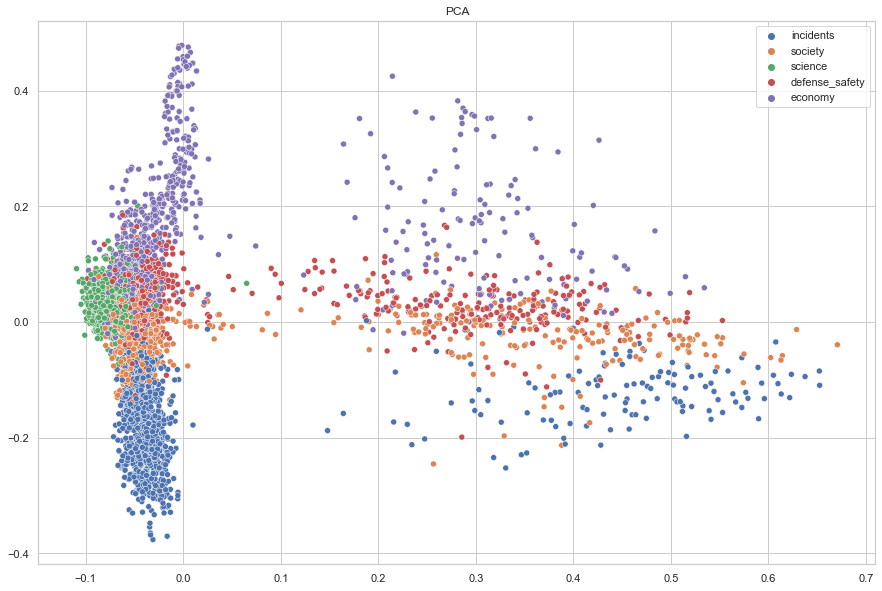

In [202]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X_train.todense())

print('Explained ratio: ', pca.explained_variance_ratio_ )
plt.figure(figsize=(15, 10))
plt.title('PCA')
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=letxt.inverse_transform(y_train), );


Можно увидеть, что при снижении размерности есть некоторые границы классов (сверху преимущественно economy, снизу - incidents). Заметим, что большая часть данных сконцентрирована слева. Ограничим данные по x и внимательнее рассмотрим левую часть графика.

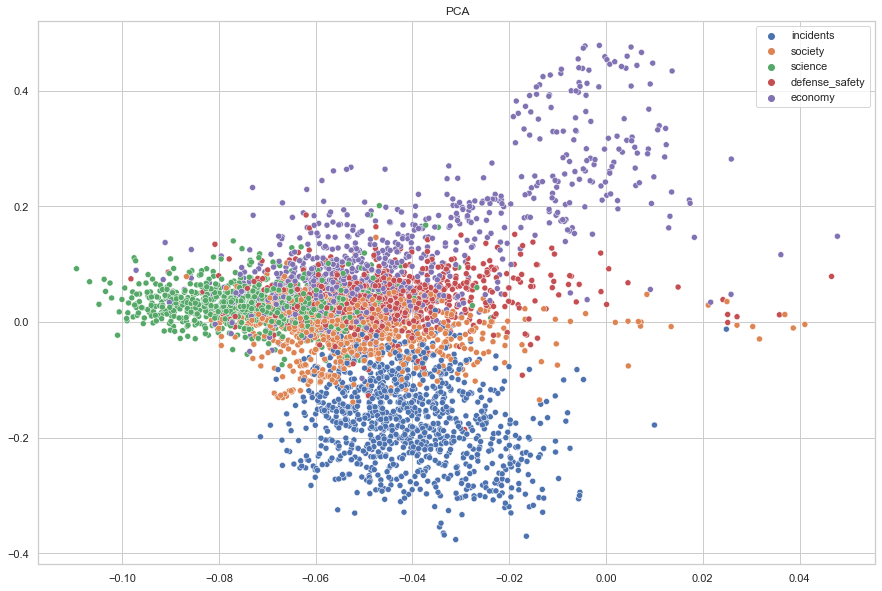

In [203]:
mask = X2D[:, 0] < 0.05

plt.figure(figsize=(15, 10))
plt.title('PCA')
sns.scatterplot(x=X2D[:, 0][mask], y=X2D[:, 1][mask], hue=letxt.inverse_transform(y_train)[mask], );

#### t-SNE

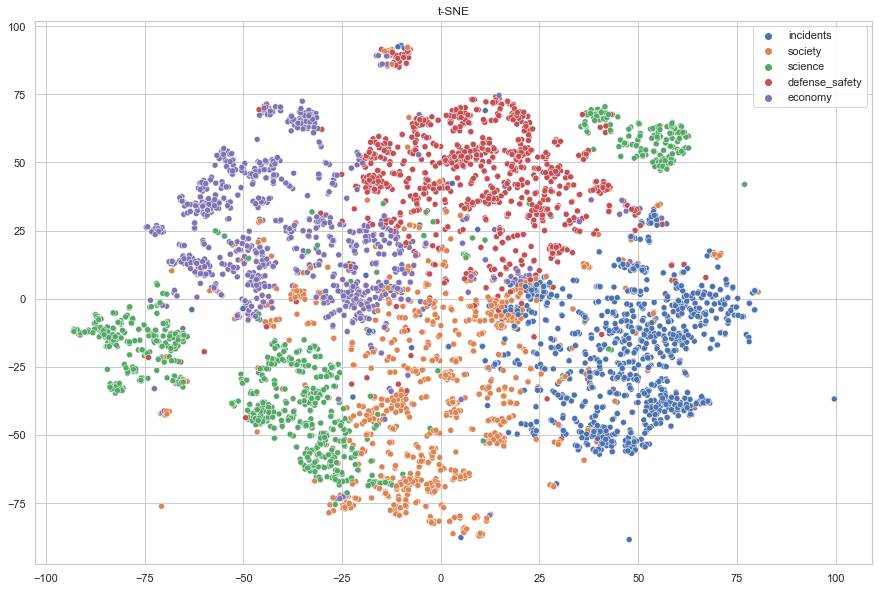

In [204]:
from sklearn.manifold import TSNE

X2D = TSNE(n_components=2, init='random', perplexity=20).fit_transform(X_train.todense())

plt.figure(figsize=(15, 10))
plt.title('t-SNE')
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=letxt.inverse_transform(y_train), );

Оба алгоритма снижения размерности показали наличие связей в данных. Даже снижая размерность данных до 2 измерений, классы имеют заметные границы. 

## 5. Базовая модель

Создадим базовую модель, от метрик которой можно будет отталкиваться в дальнейшем.

Так как нет каких-либо предпочтений по важности классификации какого либо класса, а также нет предпочтений в выборе между точностью и полнотой, в качестве основной метрики выбираем F1(macro), которая в равной степени учитывает precision и recall. 

При изображении матрицы ошибок уберем число правильно классифицированных объектов на главной диагонали, чтобы лучше выделить цветом ошибки классификации.

In [205]:
def plot_conf_matrix(y_true, y_pred, target_names, model_name=''):
    conf = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(conf, 0 ) 
    sns.heatmap(conf,
              annot=conf, 
              yticklabels=target_names,
              xticklabels=target_names,
              cmap='bwr');
    plt.title(f'{model_name}confusion matrix');
    plt.xlabel('Predicted label');
    plt.ylabel('True label');

In [206]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_p = lr.predict(X_test)
y_p_train = lr.predict(X_train)

In [207]:
print(classification_report(y_test, y_p))
print('f1 score test:', f1_score(y_test, y_p, average='macro'))
print('f1 score train:',f1_score(y_train, y_p_train, average='macro'))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       426
           1       0.93      0.95      0.94       451
           2       0.96      0.97      0.97       476
           3       0.96      0.96      0.96       422
           4       0.90      0.89      0.89       443

    accuracy                           0.94      2218
   macro avg       0.94      0.94      0.94      2218
weighted avg       0.94      0.94      0.94      2218

f1 score test: 0.939708354992632
f1 score train: 0.9718881556211361


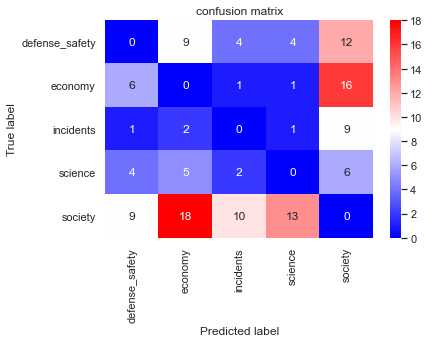

In [208]:
plot_conf_matrix(y_test, y_p, letxt.classes_)

Можно видеть, что больше всего ошибок возникло с классом society. Модель часто путала его с другими классами, что видно и по метрикам классификации (classification report). 

## 6. Выбор модели. Подбор параметров

Для оценки моделей при подборе параметров используется метод кросс-валидации. 

Подбор гиперпараметров осуществляется с помощью библиотеки hyperopt, в которой реализован подход байесовской оптимизации.

In [27]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [28]:
from functools import partial
from hyperopt import hp, fmin, STATUS_OK, tpe, space_eval

def objective(params, estim=None):
    clf = estim(**params)
    current_score = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1_macro').mean()
#     print(current_score, params)
    
    return -current_score

# def objective(params, data=None):
#     output = f(**params, data)
#     return {'loss': output ,  'status': STATUS_OK}

# fmin_objective = partial(objective, data=data)

# bestParams = fmin(fn = fmin_objective ,space = params)

Теперь подберем наиболее оптимальные параметры для всех моделей, подсчитаем метрики и построим матрицу ошибок.

### 6.1 Random Forest

In [135]:
space = {
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_depth': hp.randint('max_depth', 10, 80),
    'max_features': hp.choice('max_features', ['auto', 'sqrt']),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 3, 4, 5]),
    'min_samples_split': hp.choice('min_samples_split', [2, 3, 5, 10]),
    'n_estimators': hp.choice('n_estimators', [20, 30, 50, 80, 100, 200, 300]),
    'n_jobs' : -1,
}

# так как fn в fmin должна принимать один аргумент, зафиксируем аргумент estim как нужный классификатор 
# с помощью функции partial
fmin_objective = partial(objective, estim=RandomForestClassifier)
best = fmin(fn=fmin_objective, space=space, algo=tpe.suggest, max_evals=100)
print('best:')
print(space_eval(space, best))

100%|█████████████████████████████████████████████| 100/100 [07:28<00:00,  4.48s/trial, best loss: -0.9241288486813916]
best:
{'bootstrap': False, 'max_depth': 66, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'n_jobs': -1}


In [136]:
rndf = RandomForestClassifier(**space_eval(space, best))
rndf.fit(X_train, y_train)
y_p = rndf.predict(X_test)
print(classification_report(y_test, y_p))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       426
           1       0.92      0.94      0.93       451
           2       0.94      0.97      0.96       476
           3       0.96      0.97      0.97       422
           4       0.91      0.87      0.89       443

    accuracy                           0.94      2218
   macro avg       0.94      0.94      0.94      2218
weighted avg       0.94      0.94      0.94      2218



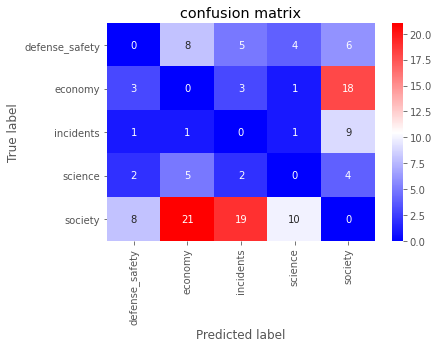

In [137]:
plot_conf_matrix(y_test, y_p, letxt.classes_)

In [138]:
dump(rndf, 'models/rndf.pkl')

['models/rndf.pkl']

In [139]:
load_rndf = load('models/rndf.pkl')
load_rndf.fit(X_train, y_train)
y_p = load_rndf.predict(X_test)
y_p_train = load_rndf.predict(X_train)
print(classification_report(y_test, y_p))
print('f1 score test:', f1_score(y_test, y_p, average='macro'))
print('f1 score train:',f1_score(y_train, y_p_train, average='macro'))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       426
           1       0.92      0.95      0.94       451
           2       0.93      0.97      0.95       476
           3       0.96      0.98      0.97       422
           4       0.91      0.85      0.88       443

    accuracy                           0.94      2218
   macro avg       0.94      0.94      0.94      2218
weighted avg       0.94      0.94      0.94      2218

f1 score test: 0.9384614459684057
f1 score train: 1.0


### 6.2 Stochastic Gradient Descent

In [66]:
space = {
    'loss' :  hp.choice('loss', [ 'log', 'modified_huber']), 
    'penalty' : 'elasticnet',
    'l1_ratio' : hp.uniform('l1_ratio', 0, 0.8),
    'alpha' : hp.uniform('alpha', 0, 0.2),
    'max_iter' : 20000,
}

fmin_objective = partial(objective, estim=SGDClassifier)
best = fmin(fn=fmin_objective, space=space, algo=tpe.suggest, max_evals=1000)
print('best:')
print(space_eval(space, best))

100%|███████████████████████████████████████████| 1000/1000 [11:15<00:00,  1.48trial/s, best loss: -0.9397899816383571]
best:
{'alpha': 4.40352664125466e-05, 'l1_ratio': 0.08910112612840657, 'loss': 'log', 'max_iter': 20000, 'penalty': 'elasticnet'}


In [75]:
space_eval(space, best)

{'alpha': 4.40352664125466e-05,
 'l1_ratio': 0.08910112612840657,
 'loss': 'log',
 'max_iter': 20000,
 'penalty': 'elasticnet'}

In [76]:
sgd = SGDClassifier(**space_eval(space, best))
sgd.fit(X_train, y_train)
y_p = sgd.predict(X_test)
y_p_train = sgd.predict(X_train)
print(classification_report(y_test, y_p))
print('f1 score test:', f1_score(y_test, y_p, average='macro'))
print('f1 score train:',f1_score(y_train, y_p_train, average='macro'))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       426
           1       0.93      0.95      0.94       451
           2       0.96      0.97      0.97       476
           3       0.95      0.96      0.96       422
           4       0.91      0.88      0.90       443

    accuracy                           0.94      2218
   macro avg       0.94      0.94      0.94      2218
weighted avg       0.94      0.94      0.94      2218

f1 score test: 0.942923781165409
f1 score train: 0.9859646422418937


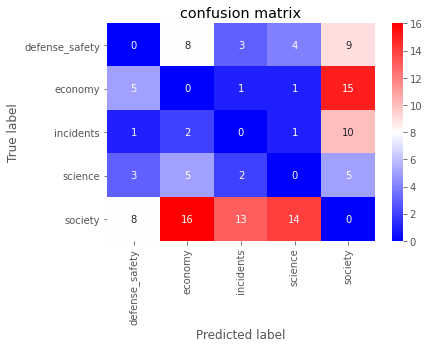

In [77]:
plot_conf_matrix(y_test, y_p, letxt.classes_)

In [78]:
dump(sgd, 'models/sgd.pkl')

['models/sgd.pkl']

### 6.3 K Nearest Neighbours

In [145]:
space = {
    'n_neighbors' : hp.choice('n_neighbors', np.arange(2, 50, 1)),
    'weights' : hp.choice('weights', ['uniform', 'distance']),
}

fmin_objective = partial(objective, estim=KNeighborsClassifier)
best = fmin(fn=fmin_objective, space=space, algo=tpe.suggest, max_evals=300)
print('best:')
print(space_eval(space, best))

100%|█████████████████████████████████████████████| 300/300 [05:31<00:00,  1.11s/trial, best loss: -0.8984637937309333]
best:
{'n_neighbors': 4, 'weights': 'distance'}


In [146]:
knn = KNeighborsClassifier(**space_eval(space, best))
knn.fit(X_train, y_train)
y_p = knn.predict(X_test)
y_p_train = knn.predict(X_train)
print(classification_report(y_test, y_p))
print('f1 score test:', f1_score(y_test, y_p, average='macro'))
print('f1 score train:',f1_score(y_train, y_p_train, average='macro'))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       426
           1       0.90      0.91      0.91       451
           2       0.90      0.95      0.93       476
           3       0.93      0.93      0.93       422
           4       0.86      0.80      0.83       443

    accuracy                           0.90      2218
   macro avg       0.90      0.90      0.90      2218
weighted avg       0.90      0.90      0.90      2218

f1 score test: 0.9039179211446324
f1 score train: 1.0


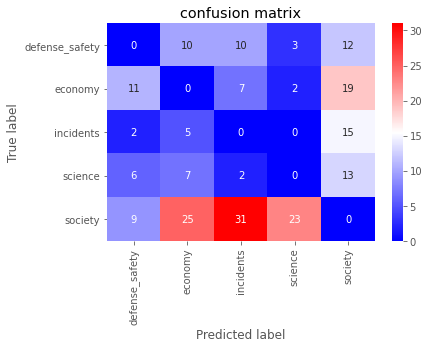

In [147]:
plot_conf_matrix(y_test, y_p, letxt.classes_)

In [148]:
dump(knn, 'models/knn.pkl')

['models/knn.pkl']

### 6.4 SVM

In [149]:
space =  {
    'C': hp.uniform('C' ,0.0001, 100), 
    'gamma': hp.uniform('gamma', 0, 1),
    'kernel': 'rbf'
}
fmin_objective = partial(objective, estim=SVC)
best = fmin(fn=fmin_objective, space=space, algo=tpe.suggest, max_evals=60)
print('best:')
print(space_eval(space, best))

100%|███████████████████████████████████████████████| 60/60 [36:22<00:00, 36.37s/trial, best loss: -0.9422340369735037]
best:
{'C': 14.549384913068616, 'gamma': 0.828246332203677, 'kernel': 'rbf'}


In [150]:
svc = SVC(**space_eval(space, best))
svc.fit(X_train, y_train)

y_p = svc.predict(X_test)
y_p_train = svc.predict(X_train)

print(classification_report(y_test, y_p))
print('f1 score test:', f1_score(y_test, y_p, average='macro'))
print('f1 score train:',f1_score(y_train, y_p_train, average='macro'))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       426
           1       0.93      0.95      0.94       451
           2       0.96      0.96      0.96       476
           3       0.97      0.96      0.97       422
           4       0.89      0.90      0.90       443

    accuracy                           0.94      2218
   macro avg       0.94      0.94      0.94      2218
weighted avg       0.94      0.94      0.94      2218

f1 score test: 0.944149633048411
f1 score train: 1.0


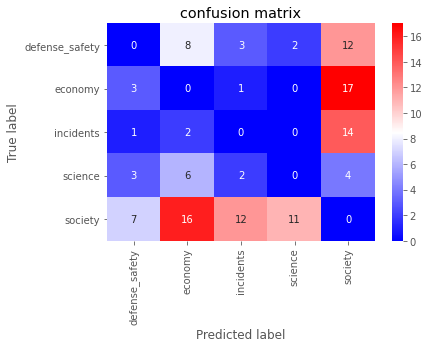

In [151]:
plot_conf_matrix(y_test, y_p, letxt.classes_)

In [152]:
dump(svc, 'models/svc.pkl')

['models/svc.pkl']

### 6.5 Наивный Байесовский Классификатор

In [35]:
space =  {
    'alpha' : hp.uniform('alpha', 0, 2),
}
fmin_objective = partial(objective, estim=MultinomialNB)
best = fmin(fn=fmin_objective, space=space, algo=tpe.suggest, max_evals=1000)
print('best:')
print(space_eval(space, best))

100%|███████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.53trial/s, best loss: -0.9309026041071721]
best:
{'alpha': 0.14412616294417266}


In [36]:
mnb = MultinomialNB(**space_eval(space, best))
mnb.fit(X_train, y_train)

y_p = mnb.predict(X_test)
y_p_train = mnb.predict(X_train)

print(classification_report(y_test, y_p))
print('f1 score test:', f1_score(y_test, y_p, average='macro'))
print('f1 score train:',f1_score(y_train, y_p_train, average='macro'))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       426
           1       0.91      0.94      0.92       451
           2       0.95      0.97      0.96       476
           3       0.93      0.96      0.95       422
           4       0.91      0.85      0.88       443

    accuracy                           0.93      2218
   macro avg       0.93      0.93      0.93      2218
weighted avg       0.93      0.93      0.93      2218

f1 score test: 0.9281217314587609
f1 score train: 0.9465217151749572


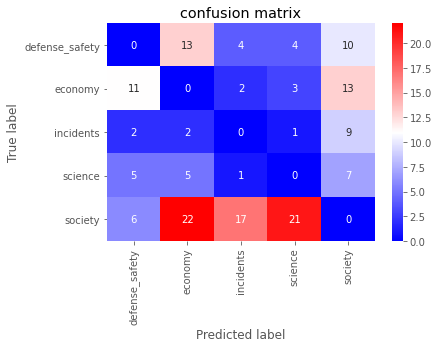

In [37]:
plot_conf_matrix(y_test, y_p, letxt.classes_)

In [38]:
dump(mnb, 'models/mnb.pkl')

['models/mnb.pkl']

### 6.6 Gradient Boosting

In [29]:
space ={
    'num_leaves' : hp.randint('num_leaves', 2, 40),
    'n_estimators' : hp.choice('n_estimators', range(100, 1201, 100)),
    'boosting_type' :  hp.choice('boosting_type', ['gbdt', 'dart']),
    'learning_rate' :  hp.uniform('learning_rate', 0.001, 0.5),
}

fmin_objective = partial(objective, estim=LGBMClassifier)
best = fmin(fn=fmin_objective, space=space, algo=tpe.suggest, max_evals=50)
print('best:')
print(space_eval(space, best))

100%|████████████████████████████████████████████████| 50/50 [56:22<00:00, 67.66s/trial, best loss: -0.929584664278034]
best:
{'boosting_type': 'gbdt', 'learning_rate': 0.08028071693699759, 'n_estimators': 600, 'num_leaves': 11}


In [30]:
lgbm = LGBMClassifier(**space_eval(space, best))
lgbm.fit(X_train, y_train)

y_p = lgbm.predict(X_test)
y_p_train = lgbm.predict(X_train)

print(classification_report(y_test, y_p))
print('f1 score test:', f1_score(y_test, y_p, average='macro'))
print('f1 score train:',f1_score(y_train, y_p_train, average='macro'))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       426
           1       0.93      0.94      0.93       451
           2       0.96      0.96      0.96       476
           3       0.97      0.95      0.96       422
           4       0.88      0.91      0.89       443

    accuracy                           0.94      2218
   macro avg       0.94      0.94      0.94      2218
weighted avg       0.94      0.94      0.94      2218

f1 score test: 0.9412059454924749
f1 score train: 1.0


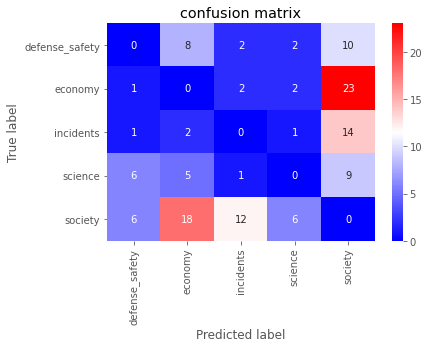

In [31]:
plot_conf_matrix(y_test, y_p, letxt.classes_)

In [32]:
dump(lgbm, 'models/lgbm.pkl')

['models/lgbm.pkl']

## 7. Сравнение результатов

Судя по всему, все классификаторы имели проблемы с классом society. Возможно, это связано с тем, что тема society является достаточно общей.

In [209]:
def metrics(est_names, X_train, y_train, X_test, y_test, estimators=None):
    results = pd.DataFrame(columns=['f1', 'f1_tr', 'time_train', 'time_inf'], index=est_names)
    if not estimators:
        estimators = [load('models/' + name + '.pkl') for name in est_names]
    for est, name in zip(estimators, est_names):
        
        clone_est = clone(est)
        
        start_fit = timeit.default_timer()
        clone_est.fit(X_train, y_train)
        stop_fit = timeit.default_timer()
        
        start_inf = timeit.default_timer()
        y_p = clone_est.predict(X_test)
        stop_inf = timeit.default_timer()
        
        y_p_tr = clone_est.predict(X_train)
        
        results.loc[name]['f1'] = round(f1_score(y_test, y_p, average='macro'), 4)
        results.loc[name]['f1_tr'] = round(f1_score(y_train, y_p_tr, average='macro'), 4)
        results.loc[name]['time_train'] = stop_fit - start_fit
        results.loc[name]['time_inf'] = stop_inf - start_inf 
#         print(name, ':')
#         print(f1_score(y_test, y_p, average='macro'))
#         print(f1_score(y_train, y_p_tr, average='macro'))
    return results

In [210]:
# ests = [rndf, sgd, svc, knn, mnb, lgbm]
est_names = ['rndf', 'sgd', 'svc', 'knn', 'mnb', 'lgbm']
res = metrics(est_names, X_train, y_train, X_test, y_test, )
res

,f1,f1_tr,time_train,time_inf
rndf,0.94,1.0,4.840019,0.198553
sgd,0.9429,0.986,0.302861,0.001999
svc,0.9441,1.0,19.540743,5.610391
knn,0.9039,1.0,0.002567,0.721328
mnb,0.9281,0.9465,0.006551,0.001808
lgbm,0.9412,1.0,43.029504,0.220504


Итоги:

* По результатам видно, что многие классификаторы довольно сильно переобучились (идеально предсказывают тренировочный набор)
* 2 лучших по F1 классификатора - SVM с rbf ядром и SGD, но SVM имеет наибольшее время предсказания. 
* Самый худший по F1 классификатор - KNN
* Алгоритм, обучавшийся дольше всего - gradient boosting
* Алгоритм, обучавшийся быстрее всего - knn

**Примечание**: результаты по времени работы алгоритмов могут сильно зависеть от гиперпараметров моделей.

Выбор итогового алгоритма зависит от поставленных целей. Если важной характеристикой является скорость предсказания, то SVM с rbf уже не будет являться предпочтительным выбором, вместо него лучше себя показал SGD. 

Результаты классификации можно улучшить, объеденив классификаторы в ансамбль (но тогда это займет еще больше времени).

In [211]:
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

estimators = [load('models/' + name + '.pkl') for name in est_names]
estimators[2].set_params(**{'probability' : True})
estimators[2]

SVC(C=14.549384913068616, gamma=0.828246332203677, probability=True)

In [212]:
est_pairs = list(zip(est_names, estimators))
v_clf = VotingClassifier(estimators=est_pairs, voting='soft')

In [213]:
%%time
v_clf.fit(X_train, y_train)

Wall time: 2min 33s


VotingClassifier(estimators=[('rndf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=66,
                                                     n_estimators=300,
                                                     n_jobs=-1)),
                             ('sgd',
                              SGDClassifier(alpha=4.40352664125466e-05,
                                            l1_ratio=0.08910112612840657,
                                            loss='log', max_iter=20000,
                                            penalty='elasticnet')),
                             ('svc',
                              SVC(C=14.549384913068616, gamma=0.828246332203677,
                                  probability=True)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                 

In [214]:
%%time
y_p = v_clf.predict(X_test)
y_p_train = v_clf.predict(X_train)

print(classification_report(y_test, y_p))
print('f1 score test:', f1_score(y_test, y_p, average='macro'))
print('f1 score train:',f1_score(y_train, y_p_train, average='macro'))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       426
           1       0.94      0.96      0.95       451
           2       0.97      0.97      0.97       476
           3       0.96      0.98      0.97       422
           4       0.91      0.91      0.91       443

    accuracy                           0.95      2218
   macro avg       0.95      0.95      0.95      2218
weighted avg       0.95      0.95      0.95      2218

f1 score test: 0.9535184696059984
f1 score train: 1.0
Wall time: 22.8 s


Можно видеть, что, используя VotingClassifier с 6 классификаторами, удалось улучшить результат, пожертвовав временем обучения и предсказания.

## 8. Важность признаков (слов)

Для SVM с rbf ядром нет возможности подсчитать важность признаков. Признаки довольно просто интерпретируются для случайного леса и градиентного бустинга (чем чаще признак находится выше в деревьях, тем он важнее). Кроме того, это небинарные классификаторы (по сравнению с SGD и SVM), поэтому при многоклассовой классификации создается лишь одна модель (для бинарных классификаторов используются методы ovr и ovo). Визуализируем важности признаков.

In [226]:
def plot_importance(est, fnames, n_best=30):
    
    name_importance = zip(fnames, est.feature_importances_)
    sorted_name_importance = sorted(name_importance, key=lambda x: x[1], reverse=True)

    all_best = sorted_name_importance[:n_best]

    required_words = [i[0] for i in all_best]
    required_coefs = [i[1] for i in all_best]

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(16, 9))
    ax = sns.barplot(x=required_coefs, y=required_words, orient='h');
    ax.set(xlabel='coefficients', ylabel='words', title='Feature Importance')
    
    return required_words

In [227]:
estimators[5].feature_importances_

array([ 0,  0,  0, ...,  0, 13,  2])

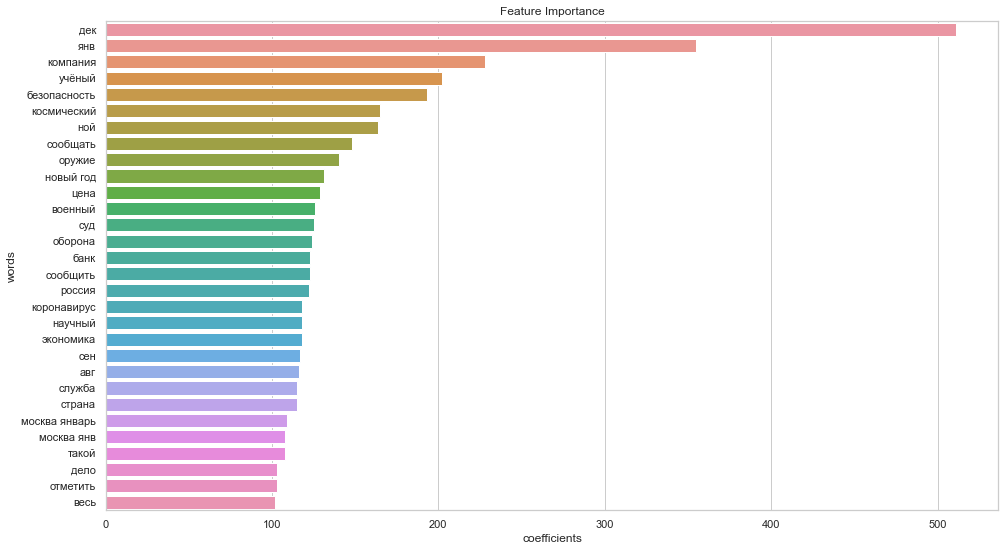

In [228]:
words_rndf = plot_importance(estimators[5], tfidf.get_feature_names())

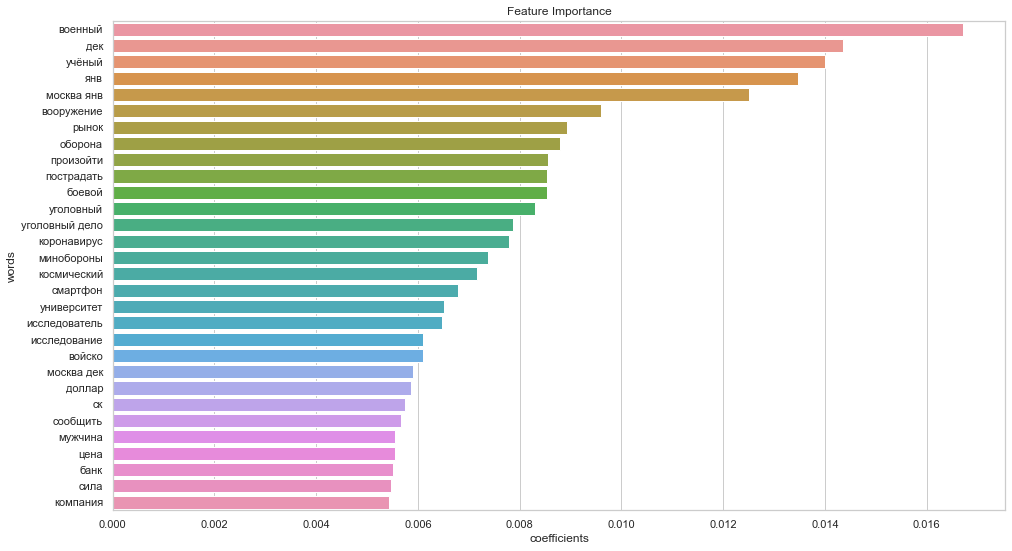

In [229]:
words_gb = plot_importance(estimators[0], tfidf.get_feature_names())

Посмотрим, какие слова и словосочетания встречались как важные для random forest и lgbm.

In [230]:
set(words_rndf) & set(words_gb)

{'банк',
 'военный',
 'дек',
 'компания',
 'коронавирус',
 'космический',
 'москва янв',
 'оборона',
 'сообщить',
 'учёный',
 'цена',
 'янв'}

Можем заметить такие слова, как банк, военный, коронавирус, оборона и тд, которые четко могут относиться к искомым классам. Но кроме них, также присутствуют такие слова, как янв, дек и тд. Возможно, алгоритмы переобучились и нашли несуществующие связи в данных, а может и сами данные содержат странную связь с названием месяцов.